# Configuration

In [1]:
#Parameters
PROJECT_NAME = 'ML1010_Weekly'
ENABLE_COLAB = True

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni/Documents/ML_Projects'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Mounted at /content/gdrive
Wha...where am I?
I am awake now.

I have set your current working directory to /content/gdrive/MyDrive/Colab Notebooks/ML1010_Weekly
The current time is 09:12
Hello sir. Extra caffeine may help.



# New Section

In [3]:
#Requirements

!pip install numpy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install rfpimp
!pip install eli5
!pip install xgboost
!pip install matplotlib

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt

np.random.seed(seed = 42)

In [5]:
# Read CSV
task_file = 'wk3_task_data.csv'
with open(jarvis.DATA_DIR + "/" + task_file, mode = 'rb') as f:
    data = pd.read_csv(f)
    
# Extract names of each column (using pandas)
headers = np.array(list(data.columns.values))
names = headers[2:]
y = data.class_label
X = pd.DataFrame(data,columns=names)


In [6]:
print(headers)

['sample index' 'class_label' 'sensor0' 'sensor1' 'sensor2' 'sensor3'
 'sensor4' 'sensor5' 'sensor6' 'sensor7' 'sensor8' 'sensor9']


In [7]:
print(names)

['sensor0' 'sensor1' 'sensor2' 'sensor3' 'sensor4' 'sensor5' 'sensor6'
 'sensor7' 'sensor8' 'sensor9']


As per problem statement, the emphasis is on identifying the importance of a particular feature in the machine learning model. This is a classification problem wherein we need to identify the important feature and we need to justify the reasons by showing why we have chosen a specific feature and how it turns out to be important feature. Identifying the important features is very important due to the followig reasons:
    1. It will help us improve the model's by concentrating on important features (variables)
    2. It will help us get rid of features that are not relevant or which don not contribute the model's performance.
    
Feature importance can be implemented using various model's the popular among them being Random forest, XGBoost, Linear Regression. My idea here is that the better the model is, the more we can rely on the feature importance and how to interepret the problem. I will explain the reason for chosing the model as we proceed.

## Exploratory data analysis

In [8]:
print(data.describe())

       class_label     sensor0     sensor1  ...     sensor7     sensor8     sensor9
count   400.000000  400.000000  400.000000  ...  400.000000  400.000000  400.000000
mean      0.000000    0.523661    0.509223  ...    0.482372    0.482822    0.541933
std       1.001252    0.268194    0.276878  ...    0.282714    0.296180    0.272490
min      -1.000000    0.007775    0.003865  ...    0.003322    0.003165    0.000452
25%      -1.000000    0.299792    0.283004  ...    0.242848    0.213626    0.321264
50%       0.000000    0.534906    0.507583  ...    0.463438    0.462251    0.578389
75%       1.000000    0.751887    0.727843  ...    0.732483    0.740542    0.768990
max       1.000000    0.999476    0.998680  ...    0.998230    0.996098    0.999465

[8 rows x 11 columns]


Text(0.5, 1.0, 'Correlation matrix')

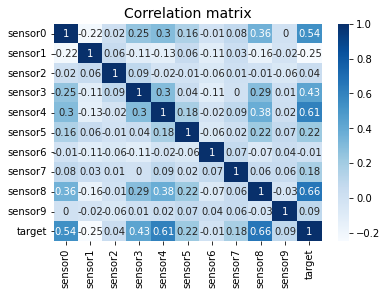

In [9]:
sns.heatmap(X.assign(target = y).corr().round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 14)

# Models:

## a ) Random Forest

Since Decision trees can be used for better interpretability of the model, the downside is that it works well if the depth is very small. Since the current dataset has only 400 data points, it might be easy to interpret the model using Decision tree, but if the aspect of scalebility is considered it might not be a best approach and this is where Random Forest comes into picture. In Random forest the subset of data is chosen which is also called as bootstrap. These bootstrap are fed to decision trees with large depths randomly. The final result is obtained by counting the majority of the vote from all the decision trees. This technique is called as boot strapping or bagging. This also helps in overcoming bais.

In order to validate the Random forest model, I have used ```oob_score```. Out of bag score(oob_score) is used when the dataset is smaller in size. Since validation score requires us to keep apart certain part of da
ta, it is good to use oob_score since it works only on subset of decision trees and while the validation score is calculated on all the decision trees.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

rf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [11]:
#print('Score :', rf.score(X_test,y_test))

print('Out of bag error:', rf.oob_score_)

Out of bag error: 0.985


As we can obersve that the model performed well on the training set. The ```oob_score``` obtained is also good. I will now check which feature is more important and try to visulaize it. This will help us understand which feature has to be given more importance.

In Scikit learn, we can use the feature importance by just using the decision tree which can help us in give some prior intution of th features. Decision Tree is one of the machine learning algorithms that is used for a range of classification and
regression problems and more specifically in the decision analysis problems. Decision tree provides a tree-like structure which comprises od decisions that can be made based on a hypothesis. A decision tree is represented in an upside-down where each node represents a feature also called attribute and each brach also called link to the nodes is represents a decision or condition for selecting the specific node. The top node of the tree is called the root node and the bottom-most nodes are called the leaf
nodes. The main idea behind using a decision tree is to represent the whole data in the form of a tree.  
    It has some advantages such as it is faster and it is easier to implement. The downside is it suffers from bias problem due to high cardinality and inflate the importance of continous featues.

In [12]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'green') \
       .set_title(title, fontsize = 20)

In [13]:
base_imp = imp_df(X.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,sensor8,0.256427
1,sensor6,0.199622
2,sensor4,0.198249
3,sensor0,0.149611
4,sensor2,0.063839
5,sensor3,0.042247
6,sensor1,0.036030
7,sensor9,0.019462
8,sensor5,0.017295
9,sensor7,0.017217


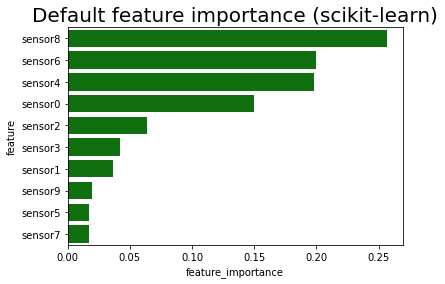

In [14]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

Using the default feature importance of Scikit-learn we can get the below mentioned graph. As we can notice that the top features are from ````Sensor8, Sensor4 and Sensor6```` .



[ Reference : https://scikit-learn.org/stable/modules/feature_selection.html ]


This default feature importance doesn't gives a proper picture of feature importance. This is because the there is bias involved in this method .[ Reference https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp ]. Another issue is the collinearity and the inflation towards the continous values.

Hence we need to find a better method.

# Other method to check the feature importance.

There are other ways to check the feature importance and I have chosen the following:


 ###   1. Permutation feature importance : 
        In this method we first train the model and calculate the score by passing validation set (or OOB set in case of Random Forest). We call this score as benchmark result. We then re shuffle the values from one feature in the dataset and then pass it to the model to calcualte the score again. We then calculate the feature importance score which the the difference between the score obtained after shuffling the data and benchmark result. We repeat this process for all the features. 
        This method has advantages like it is applicable to any model, reasonably efficient, reliable technique and no need to retrain the model at each modification of the dataset. The downside is it is more computationally expensive than default feature_importances permutation importance overestimates the importance of correlated predictors - Strobl et al (2008)
        
        
        [ Reference :https://explained.ai/rf-importance/index.html#5 ]

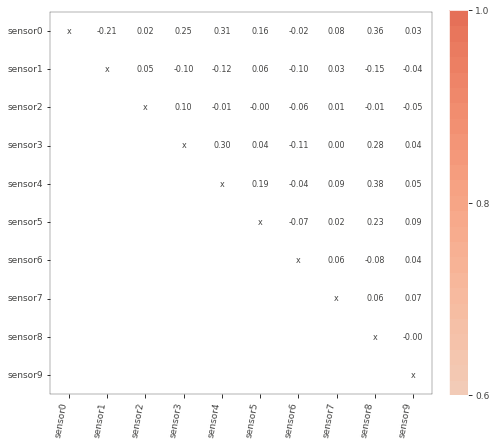

In [16]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X, figsize=(7,7))
viz.view()

In [17]:
#Referring the code from https://explained.ai/rf-importance/index.html#5
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X, y):
    return r2_score(y, rf.predict(X))

perm_imp_rfpimp = permutation_importances(rf, X, y, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

In [18]:
#Referring the code from https://explained.ai/rf-importance/index.html#5

from rfpimp import *
rf_pimp = RandomForestClassifier(n_estimators=100, n_jobs=-1)
%time I = oob_importances(rf_pimp, X, y)

CPU times: user 792 ms, sys: 36.6 ms, total: 828 ms
Wall time: 796 ms


In [19]:
%time I = cv_importances(rf_pimp, X, y, k=5)

CPU times: user 9.98 s, sys: 435 ms, total: 10.4 s
Wall time: 20.4 s


In [20]:
%time I = dropcol_importances(rf_pimp, X, y)

CPU times: user 3.06 s, sys: 397 ms, total: 3.46 s
Wall time: 3.87 s


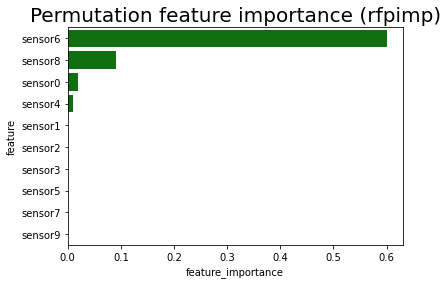

In [21]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

As we can notice that the permutation method gives a different result when compared to the Scikit learn's default feature importance. In this result the ```sensor 6 ``` turned out to be more important. Even though ```sensor 8 ``` is still an important feature and is among the top 4 values, this helped us to overcome the issue of collinearity which the default feature importance method suffer's with

As we can notice that the time take to get the feature importance using permutation method is much less. This will be beneficial when the dataset is very small as in this case. However this method will suffer badly when compared to default feature importance method when the size of the data increases. Hence its not scalable.

Another feature importance method is using eli5 which is another option present in scikit learn.
[Reference : http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html]

This method shows us a way where in we can check how the score will reduce if a particular feature is not present. Since the number of features present is not more for this problem, this method is not power intensive(resource consumption), otherwise it might suffer if the number of features increase. 

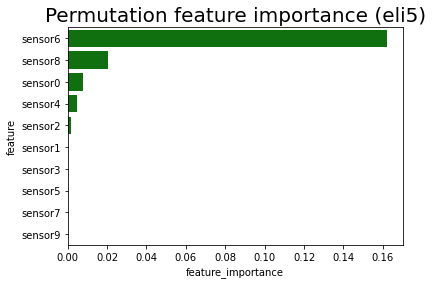

In [22]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X, y)
perm_imp_eli5 = imp_df(X.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

In [23]:
eli5.show_weights(perm)

Weight,Feature
0.1619 ± 0.0242,x6
0.0203 ± 0.0100,x8
0.0078 ± 0.0054,x0
0.0046 ± 0.0047,x4
0.0016 ± 0.0034,x2
0 ± 0.0000,x9
0 ± 0.0000,x7
0 ± 0.0000,x5
0 ± 0.0000,x3
0 ± 0.0000,x1


As we can notice that by using this method we got the similar result as we obtained via rfpimp. This gives us a better undertanding that the ```sensor 6 ``` is an important feature. It has more weightage.

There are other feature selection methods mentioned in Scikit learn such as ```lasso```  but I haven't used them. 

[Reference : https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-boston-py ] 

### 2.  Check the feature importance by dropping a column
I will now check how the model behaves if we drop certain coloumn features for training. This helps us justify our previous benchamarks and results that we have obtained. We will check if the ```sensor6``` feature turns out to be the important one which we have see above.

In [24]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feat

CPU times: user 2.54 s, sys: 272 ms, total: 2.82 s
Wall time: 4.21 s
   feature  feature_importance
0  sensor5            0.005149
1  sensor8            0.003756
2  sensor6            0.003359
3  sensor2           -0.000010
4  sensor7           -0.000256
5  sensor1           -0.000508
6  sensor3           -0.001101
7  sensor9           -0.001242
8  sensor0           -0.001343
9  sensor4           -0.014849


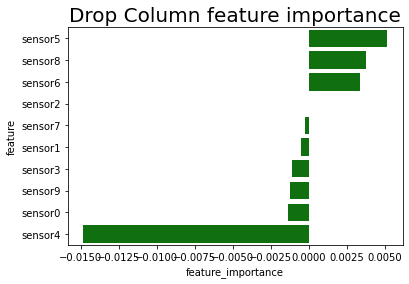

In [25]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

rf_1 =  RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

rf_1.fit(X_train, y_train)
%time drop_imp = drop_col_feat_imp(rf_1, X_train, y_train)
print(drop_imp)
var_imp_plot(drop_imp, 'Drop Column feature importance')

Now as we can see that certain features if dropped causes high impact both positively and negatively. As we can see sensors ```8,5,6``` and sensors ```4,0,9``` causes high impact on the overall model performance. This is one of the most important and accuracte feature selection method. The negative importance in this case means the model performance will improve if we remove these features. Another surprising thing to note is that ```sensor 4``` which was one of the important features in observed previously, turns out to be a negative impacting feature.

This method has one downfall which is comptutation cost. The reason for chosing random forest regressor in this method was that I wanted to see how dropping each feature causes the impact on the model. If we use the random forest classification, it will simply classify either 1 or -1 and we cannot derive any meaning out of it. 

## b) XGBoost classifier

[0.05087308 0.02214793 0.02703828 0.00278934 0.08802208 0.
 0.13018082 0.         0.6610094  0.0179391 ]


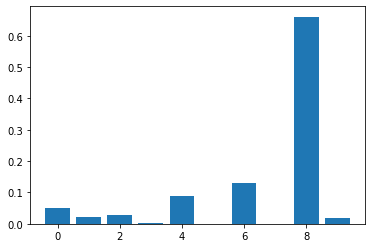

In [26]:
xgb = XGBClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)
xgb.fit(X, y)
# feature importance
print(xgb.feature_importances_)

# plot using default scikit learn feature selection 
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

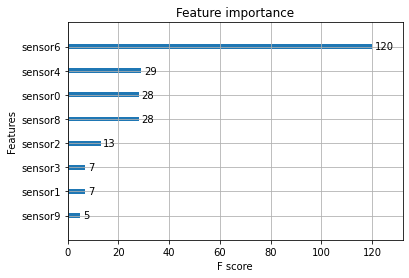

In [27]:
# plot feature importance using XGBOOST 
plot_importance(xgb)
plt.show()

# Conclusion : 
    From the above I can conclude that sensor 6 turns out to be an important feature. I have also explained the reasons for chosing the models and methods. The permutation method helps us to identify the feature importance by eliminating bias, on the other hand I explained the downside of it as well.
    
    BAlternatively, I have used XGBoost feature importance and it turned out that the scikit learn default feature_importance gives the same result as previous ones but surprisingly, XGBOOST feature importance gives similar results as seen in the permuatation method because in boosting as we saw there is not much correlation between the features , boosting will use the feature that is not correlated since correlated feature will not be used in the splitting process.